In [3]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

In [4]:
# Coordinate per la prima linea
x1 = [0, 1, 3, 3, 4]
y1 = [0, 2, 4, 6, 8]

# Coordinate per la seconda linea
x2 = [0, 1, 3, 3, 4]
y2 = [8, 6, 4, 2, 0]

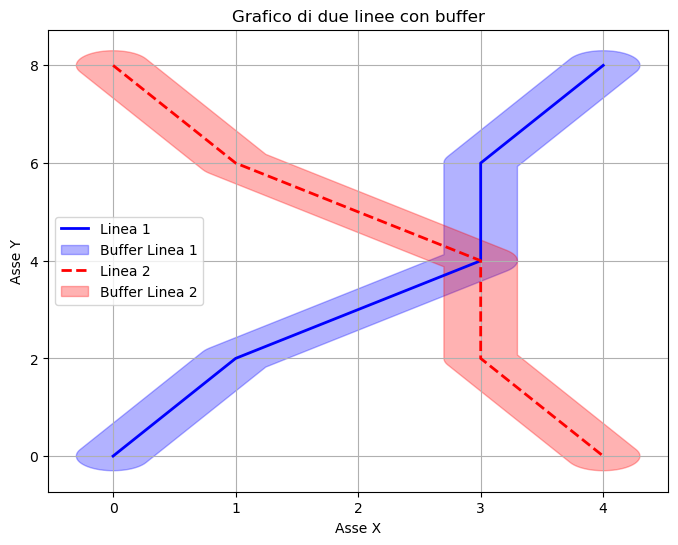

In [5]:
# Creazione delle linee usando Shapely
line1 = LineString(list(zip(x1, y1)))
line2 = LineString(list(zip(x2, y2)))

# Creazione dei buffer per le due linee
buffer1 = line1.buffer(0.3)
buffer2 = line2.buffer(0.3)

# Creazione del grafico
plt.figure(figsize=(8, 6))

# Plot della prima linea e del suo buffer
plt.plot(x1, y1, label="Linea 1", linewidth=2, color='blue')
plt.fill(*buffer1.exterior.xy, alpha=0.3, color='blue', label="Buffer Linea 1")

# Plot della seconda linea e del suo buffer
plt.plot(x2, y2, label="Linea 2", linewidth=2, linestyle='--', color='red')
plt.fill(*buffer2.exterior.xy, alpha=0.3, color='red', label="Buffer Linea 2")

# Aggiunta di etichette e titolo
plt.xlabel("Asse X")
plt.ylabel("Asse Y")
plt.title("Grafico di due linee con buffer")

# Aggiunta di una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

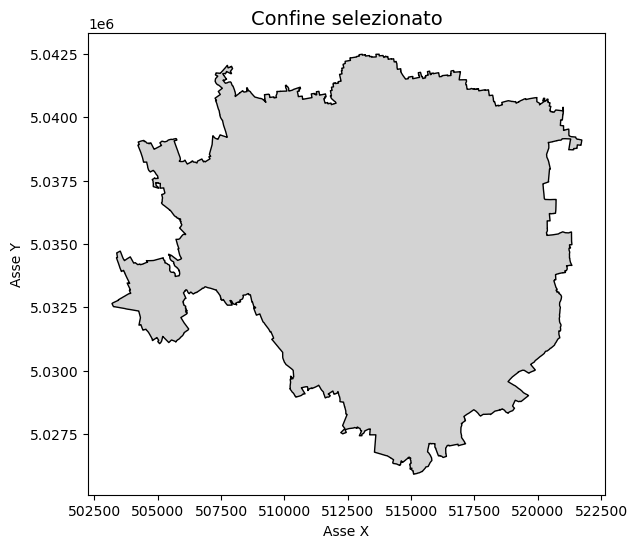

In [6]:
# Path dello shapefile
pathborder = r"C:\Users\andre\OneDrive\Documenti\Filippo\Università\24_Corsi\061938_Geospatial_processing\Project\shp\Confine_milano.shp"

# Lettura dello shapefile
border_gdf = gpd.read_file(pathborder)

# Creazione del grafico con Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
border_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Personalizzazione del grafico
ax.set_title("Confine selezionato", fontsize=14)
ax.set_xlabel("Asse X")
ax.set_ylabel("Asse Y")

# Mostra il grafico
plt.show()

CRS originale: EPSG:32632


C:\Users\andre\AppData\Local\Temp\ipykernel_3976\708951412.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  border_union = border_gdf.unary_union
C:\Users\andre\AppData\Local\Temp\ipykernel_3976\708951412.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


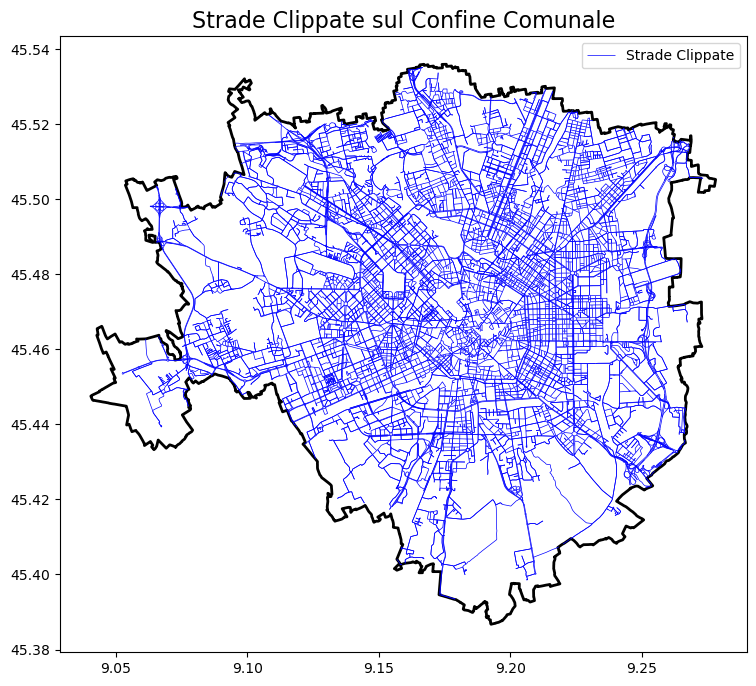

In [7]:
# Lettura del confine comunale
border_gdf = gpd.read_file(pathborder)

# Verifica del sistema di coordinate attuale
print("CRS originale:", border_gdf.crs)

# Trasforma il confine in WGS84 (EPSG:4326)
if border_gdf.crs.to_epsg() != 4326:
    border_gdf = border_gdf.to_crs(epsg=4326)

# Unione delle geometrie nel caso il confine abbia più poligoni
border_union = border_gdf.unary_union

# Scarica il grafo stradale per un'area vasta attorno al confine
grafo = ox.graph_from_polygon(border_union, network_type='drive')

# Conversione del grafo in GeoDataFrame
edges = ox.graph_to_gdfs(grafo, nodes=False, edges=True)

# Clipping delle strade in base al confine comunale
edges_clipped = gpd.clip(edges, border_union)

# Plot delle geometrie clippate
fig, ax = plt.subplots(figsize=(10, 8))
border_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label="Confine Comunale")
edges_clipped.plot(ax=ax, color='blue', linewidth=0.5, label="Strade Clippate")

# Personalizzazione del grafico
ax.set_title("Strade Clippate sul Confine Comunale", fontsize=16)
ax.legend()
plt.show()

In [32]:
# Mantieni solo le categorie singole (escludi le liste)
edges["highway"] = edges["highway"].apply(
    lambda x: x[0] if isinstance(x, list) else x
)

# Filtra le categorie multiple (le liste sono già eliminate con la trasformazione)
edges = edges[~edges["highway"].str.contains(", ")].copy()  # Usa .copy() per evitare SettingWithCopyWarning

# Raggruppa per categoria e calcola la somma delle lunghezze
densities = edges.groupby("highway")["length_km"].sum().reset_index()

# Calcola l'area totale del confine in chilometri quadrati (km²)
area_km2 = border_gdf.geometry.to_crs(epsg=3395).area.sum() / 1e6  # EPSG:3395 è in metri

# Calcola la densità (km/km²)
densities["density_km_per_km2"] = densities["length_km"] / area_km2

# Arrotonda i valori
densities["density_km_per_km2"] = densities["density_km_per_km2"].round(3)
densities["length_km"] = densities["length_km"].round(1)

# Ordina i risultati in ordine decrescente di densità
densities = densities.sort_values(by="density_km_per_km2", ascending=False)

# Rinomina la colonna "highway" in "category"
densities.rename(columns={"highway": "category"}, inplace=True)

# Reimposta l'indice (elimina la prima colonna dell'indice vecchio)
densities.reset_index(drop=True, inplace=True)

# Stampa i risultati
print(densities)

          category  length_km  density_km_per_km2
0      residential      977.5               2.652
1     unclassified      617.4               1.675
2         tertiary      389.4               1.056
3        secondary      182.2               0.494
4          primary      128.4               0.348
5    motorway_link       61.9               0.168
6         motorway       44.4               0.121
7            trunk       31.6               0.086
8       trunk_link       18.1               0.049
9     primary_link        4.5               0.012
10   living_street        4.6               0.012
11   tertiary_link        4.3               0.012
12  secondary_link        3.6               0.010
13          busway        2.3               0.006
14   emergency_bay        0.2               0.001


In [14]:
print(edges["highway"].apply(type).value_counts())


highway
<class 'str'>     25288
<class 'list'>      149
Name: count, dtype: int64
